In [1]:
import math
import numpy as np
import sys
#import cv2
import pickle
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['figure.figsize'] = (10.0, 10.0)

In [3]:
input_filename = "data/LAMP_80s_240mpp_ratio_albed_01.img"
shape = (2501, 2501) # matrix size
dtype = np.float32 # big-endian unsigned integer (16bit)
output_filename = "LAMP_BRITE.PNG"

In [4]:
height = np.reshape(np.fromfile(open("data/LDEM_75S_120M.IMG",
                                     'rb'), np.int16),
                    (7624,7624))
albedo = np.reshape(np.fromfile(open("data/LDAM_50S_1000M_FLOAT.IMG",
                                     'rb'), np.float32),
                    (2532,2532))
LAMP_ratio_albed = np.reshape(np.fromfile(open("data/LAMP_80s_240mpp_ratio_albed_01.img",
                                     'rb'), np.float32),
                    (2501,2501))
LAMP_ratio_brite = np.reshape(np.fromfile(open("data/LAMP_80s_240mpp_ratio_brite_01.img",
                                     'rb'), np.float32),
                    (2501,2501))

In [5]:
import cv2

height = height[1311:-1311,1311:-1311]
albedo = albedo[966:-966,966:-966]

#height = cv2.resize(height, dsize=LAMP_ratio_albed.shape)
lamp_brite = cv2.resize(LAMP_ratio_brite, dsize=height.shape)
lamp_albed = cv2.resize(LAMP_ratio_albed, dsize=height.shape)
albedo = cv2.resize(albedo, dsize=height.shape)

In [6]:
threshold_albedo = 0.35
threshold_lamp_ratio = 1.2

In [7]:
image = albedo > threshold_albedo

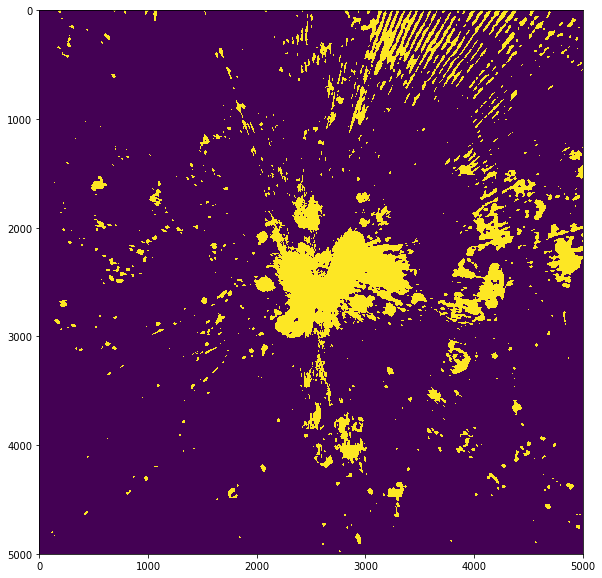

In [8]:
plt.imshow(image)
plt.savefig(output_filename)
plt.show()

In [9]:
np.array([True, True, False, False]) & np.array([True, False, True, False])  

array([ True, False, False, False])

In [10]:
POI = ((lamp_albed > threshold_lamp_ratio) & 
        (lamp_brite > threshold_lamp_ratio) & 
        (albedo > threshold_albedo))

/home/georgesmss/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


In [11]:
top_left = (1500,450)
bottom_right = (top_left[0] + 200, top_left[1] + 200)

In [12]:
POI2 = POI * 200

In [13]:
POI3 = POI2
POI3[top_left[0]:top_left[0]+10,top_left[1]:bottom_right[1]] = 255 #upper bar
POI3[bottom_right[0]:bottom_right[0]+10,top_left[1]:bottom_right[1]] = 255 #lower bar
POI3[top_left[0]:bottom_right[0],top_left[1]:top_left[1]+10] = 255 #to the left
POI3[top_left[0]:bottom_right[0],bottom_right[1]:bottom_right[1]+10] = 255 #to the right

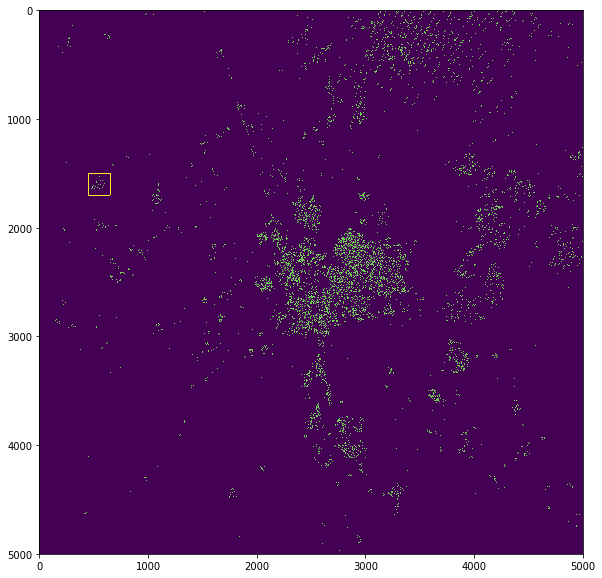

In [14]:
plt.imshow(POI3)
plt.savefig("agua_no_polo_sul_da_lua_uau.png")
plt.show()

# Optimization Step

In [16]:
m_per_px = 120
rover_max_dist_m = 24000
rover_max_dist_px = int(rover_max_dist_m / m_per_px) + 1

In [17]:
POI_little = POI[top_left[0]:top_left[0]+rover_max_dist_px,
                top_left[1]:top_left[1]+rover_max_dist_px]
POI_little.shape

(201, 201)

In [18]:
height_little = height[top_left[0]:top_left[0]+rover_max_dist_px,
                        top_left[1]:top_left[1]+rover_max_dist_px]
height_little.shape

(201, 201)

In [19]:
import copy

In [20]:
POI_little_filter = copy.deepcopy(POI_little)

In [21]:
for i in range(2,rover_max_dist_px-2):
    for j in range(2,rover_max_dist_px-2):
        POI_little_filter[i,j] =(
                                POI_little[i-1,j-1] & POI_little[i-1,j] & POI_little[i-1,j+1] & 
                                POI_little[i,j-1] & POI_little[i,j] & POI_little[i,j+1] & 
                                POI_little[i+1,j-1] & POI_little[i+1,j] & POI_little[i+1,j+1])
        
                            

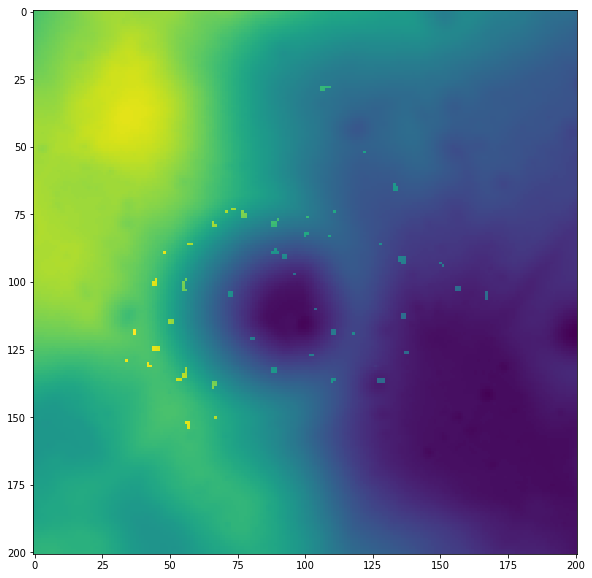

In [26]:
plt.imshow(height_little+2000*POI_little_filter)

In [33]:
list_of_POI = []
for i in np.arange(rover_max_dist_px):
    for j in np.arange(rover_max_dist_px):
        if POI_little_filter[i,j]:
            list_of_POI.append((i,j))

In [34]:
list_of_POI = np.array(list_of_POI)

In [39]:
math.ceil(len(list_of_POI) /10)

15

In [40]:
from sklearn.cluster import KMeans

k=math.ceil(len(list_of_POI) /10)

kmeans = KMeans(n_clusters=k, random_state=0).fit(list_of_POI)

In [41]:
kmeans.labels_

array([ 3,  3,  3,  3,  3,  3, 11, 11, 11, 11, 11, 11,  4,  4,  4,  4,  0,
        4,  4,  4,  4,  0,  6,  4,  6,  6,  4,  4,  6,  6,  0,  0,  0,  0,
       12, 12, 10,  6, 12,  6,  6,  6,  6,  6,  6,  6, 10, 10, 10, 10, 10,
       10, 10, 10,  9,  9,  6, 12, 12, 12, 12, 12, 12, 12, 12, 12,  9,  9,
       12, 12,  9,  9, 14, 14,  9, 14, 14,  9,  9, 13,  2,  2,  2,  2,  1,
        1,  1,  1,  1, 13, 13,  1, 13, 13, 13,  5,  5,  1,  1,  1,  1,  1,
        1,  2,  2, 13, 13,  1,  1,  1,  1,  7,  5,  5,  7,  5,  5,  7,  7,
        7,  7,  7,  7,  8,  8,  8,  8,  8,  7,  7,  8,  8,  8,  8,  7,  7,
        7,  7,  7,  7,  7,  7], dtype=int32)

In [43]:
center = kmeans.cluster_centers_

In [46]:
center

array([[ 80.        , 103.66666667],
       [122.6875    ,  44.1875    ],
       [117.        , 136.83333333],
       [ 28.33333333, 107.16666667],
       [ 75.63636364,  73.09090909],
       [128.66666667,  85.83333333],
       [ 86.07142857,  90.42857143],
       [140.27777778,  59.27777778],
       [136.44444444, 122.11111111],
       [101.33333333, 158.66666667],
       [ 91.22222222, 135.22222222],
       [ 63.        , 131.5       ],
       [ 97.85714286,  51.28571429],
       [119.625     , 108.625     ],
       [104.5       ,  72.5       ]])

In [36]:


list_of_POI

(142, 2)

In [23]:
sum(sum(POI_little_filter))

142

In [24]:
rover_max_dist_px

201

In [159]:
import networkx as nx

In [160]:
G=nx.DiGraph()

In [161]:
for i in np.arange(rover_max_dist_px):
    for j in np.arange(rover_max_dist_px):
        G.add_node((i,j))

In [ ]:
def weight_linear(i1, j1, i2, j2):
    height1 = height_little[i1,j1]
    height2 = height_little[i2,j2]
    delta = abs


def weight_diagonal(i1, j1, i2, j2):

In [ ]:
for i in np.arange(rover_max_dist_px) - math.floor(rover_max_dist_px/2):
    for j in np.arange(rover_max_dist_px) - math.floor(rover_max_dist_px/2):
        G.add_edge((i,j),(i,j+1), weight=  )
        G.add_edge((i,j+1),(i,j), "distance" = )
        G.add_edge((i,j),(i+1,j+1), "distance" = )
        G.add_edge((i+1,j+1),(i,j), "distance" = )
        G.add_edge((i,j),(i+1,j), "distance" = )
        G.add_edge((i+1,j),(i,j), "distance" = )

In [35]:
G.add_nodes_from([(1,1), (1,2), (2,1), (2,2)])

In [37]:
G.node[(1,1)].

{}

In [ ]:
G.add_edge(1, 2)
e = (2, 3)
G.add_edge(*e)  # unpack edge tuple*

In [ ]:
G = nx.path_graph(5)
path = nx.single_source_shortest_path(G, 0)
path[4]